[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/da-python/python-for-data-analytics/blob/main/Lesson3/hometask/hometask_SyntheticRubber.ipynb)

In [8]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from tqdm.auto import tqdm

In [2]:
# Для работы с API может потребоваться обходное решение для работы с SSL сертификатом
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Задание 1.

* Вы - менеджер по продажам в нефтехимической компании.
* Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании.
* Ваши клиенты предпочитают формульный подход к ценообразованию и вам нужно предложить клиентам формулу цены на синтетический каучук, который может быть альтернативой натуральному каучуку с грейдом SMR 20.
* В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента…

In [9]:
# Из данных есть:
# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии)
# location - локация клиента
# volumes - закупаемые объемы
# formula - предпочитаемая формула расчета цены - скользящая средняя или среднее значение за месяц

customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'formula':'moving_average'
    },

    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'formula': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'formula': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'formula': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


In [10]:
# Котировки натурального каучука доступны на сайте,  https://www.lgm.gov.my
# также у них есть API, пример запроса ниже


# Делаю выгрузку за месяц, с сайта нет возможности скачать в цикле остальные месяцы. 
# Обходное решение нашел, если скачать данные в новом блокноте, то появляется возможность сделать выгрузку.
# не реализовал в рамках задания (не успел)


year = '2022'
month = '07'
url = f"https://www.lgm.gov.my/webv2api/api/rubberprice/month={month}&year={year}"
res = requests.get(url)
rj = res.json()
df = pd.json_normalize(rj)

df.head()




,date,grade,masa,rm,us,tone
0,2022-07-29,SMR CV,Noon,905.00,206.80,Quiet
1,2022-07-29,SMR L,Noon,895.00,204.50,Quiet
2,2022-07-29,SMR 5,Noon,693.00,158.35,Quiet
3,2022-07-29,SMR GP,Noon,690.00,157.70,Quiet
4,2022-07-29,SMR 10,Noon,683.00,156.10,Quiet


In [11]:
# На рынке натурального каучука в этот период все тихо/спокойно 

df['tone'].unique()

array(['Quiet', 'Quietly Steady', 'Steady'], dtype=object)

In [12]:


df_smr_20 = df.loc[df['grade'] == 'SMR 20'].reset_index() #новый фрейм - каучук с грейдом SMR 20

df_smr_20 = df_smr_20.drop(columns='index') # появилась лишняя колонка, удалил

df_smr_20.date = pd.to_datetime(df_smr_20.date) #меняю дату для дальнейших манипуляций - inner merge далее


df_smr_20.head()

,date,grade,masa,rm,us,tone
0,2022-07-29,SMR 20,Noon,681.00,155.60,Quiet
1,2022-07-28,SMR 20,Noon,680.50,155.40,Quiet
2,2022-07-27,SMR 20,Noon,682.00,155.55,Quiet
3,2022-07-26,SMR 20,Noon,692.50,158.10,Quietly Steady
4,2022-07-25,SMR 20,Noon,690.50,157.70,Quietly Steady


In [149]:
# здесь можно было не выгружать рубль и доллар, в примере было, не стал исправлять

# курс евро к доллару 'EURUSD=X'
# курс евро к рублю 'EURRUB=X'
# курс доллара к рублю 'USDRUB=X'

In [13]:
df_dict = {}
for ticker in tqdm(['USDRUB=X', 'EURUSD=X', 'EURRUB=X']):
    df = yf.download(ticker)
    df = df.Close.copy()
    #df = df.resample('M').mean()
    df_dict[ticker] = df

  0%|          | 0/3 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
df = pd.DataFrame(df_dict) # создаем фрейм 
df_mean = df.loc['2022-07-01':'2022-07-31'] # создаю фрейм, выборка по датам

df_mean = df_mean.reset_index()
df_mean = df_mean.rename(columns={'Date':'date'}) # меняю название колонки для дальнейшего использования merge

In [15]:
import numpy as np

df_all = pd.merge(df_smr_20,df_mean)    # inner объединение
df_all = df_all.drop(columns=['masa','rm','tone'])    # удаляю лишнее

df_all = df_all.astype({'us':np.float})     # меняю тип данных в колонке 

/var/folders/m9/x7jxk9jx2g9ch4ngnwz3n8wh0000gn/T/ipykernel_7419/2075825014.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_all = df_all.astype({'us':np.float})     # меняю тип данных в колонке


In [16]:
df_all

,date,grade,us,USDRUB=X,EURUSD=X,EURRUB=X
0,2022-07-29,SMR 20,155.60,62.465000,1.019233,60.304699
1,2022-07-28,SMR 20,155.40,59.340000,1.020929,60.730202
2,2022-07-27,SMR 20,155.55,60.090000,1.012956,58.890900
3,2022-07-26,SMR 20,158.10,58.465000,1.022495,59.380600
4,2022-07-25,SMR 20,157.70,58.090000,1.020023,58.506199
5,2022-07-22,SMR 20,155.90,57.965000,1.022108,57.586800
6,2022-07-21,SMR 20,158.50,54.965099,1.018278,55.344002
7,2022-07-20,SMR 20,157.80,56.465000,1.023133,57.248199
8,2022-07-19,SMR 20,158.95,57.715000,1.014518,57.396999
9,2022-07-18,SMR 20,156.30,110.674103,1.009632,57.491001


In [ ]:
# Гугл, быстрый ответ: Натуральные каучуки очень дороги; 
# с другой стороны, синтетические каучуки дешевле. 
# Натуральный каучук обладает большей термостойкостью; с другой стороны, синтетические каучуки более термостойкие. 
# Натуральный каучук по качеству намного лучше синтетического. 
# Натуральный каучук не так уж и специфичен по своим характеристикам по сравнению с синтетическим каучуком.



In [ ]:
# так же важная информация :)
# Несмотря на попытки нашей страны производить натуральный каучук из одуванчиков, 
# эксперимент оказался экономически нецелесообразен: в России просто нет такого количества одуванчиков, 
# чтобы произвести каучук в необходимых объемах.


In [ ]:
# Исходя из анализа рынка и отсутствии одуванчиков, которые  безжалостно удаляются
# тримерами, была выбрана базовая цена на каучук - цена SMR 20 - 20%

In [17]:

# меняю наименования колонок

df_all = df_all.rename(columns={'USDRUB=X':'usdrub', 'EURUSD=X':'eurusd', 'EURRUB=X':'eurrub'})



In [18]:
df_all.tail()

,date,grade,us,usdrub,eurusd,eurrub
15,2022-07-07,SMR 20,161.40,63.514999,1.018641,63.789200
16,2022-07-06,SMR 20,159.45,63.465099,1.025767,60.218800
17,2022-07-05,SMR 20,163.35,54.500000,1.043319,57.525600
18,2022-07-04,SMR 20,165.30,53.237499,1.043395,119.526802
19,2022-07-01,SMR 20,164.80,54.840000,1.047768,55.165401


In [19]:

#Базовые цены 
df_all['MWP_PRICE_EUR'] = df_all.us * 0.8 * (1/df_all.eurusd) # Это то место, где использовал котировки
df_all['MWP_PRICE_USD'] = df_all.us * 0.8

df_all['MWP_PRICE_EUR_EU'] = df_all['MWP_PRICE_EUR'] + EU_LOGISTIC_COST_EUR
df_all['MWP_PRICE_USD_CN'] = df_all['MWP_PRICE_USD'] + CN_LOGISTIC_COST_USD
df_all['MWP_PRICE_EUR_EU_MA'] = df_all.MWP_PRICE_EUR_EU.rolling(window=3).mean()

In [20]:
df_all.tail()

,date,grade,us,usdrub,eurusd,eurrub,MWP_PRICE_EUR,MWP_PRICE_USD,MWP_PRICE_EUR_EU,MWP_PRICE_USD_CN,MWP_PRICE_EUR_EU_MA
15,2022-07-07,SMR 20,161.40,63.514999,1.018641,63.789200,126.757106,129.12,156.757106,259.12,157.620748
16,2022-07-06,SMR 20,159.45,63.465099,1.025767,60.218800,124.355686,127.56,154.355686,257.56,156.156603
17,2022-07-05,SMR 20,163.35,54.500000,1.043319,57.525600,125.254161,130.68,155.254161,260.68,155.455651
18,2022-07-04,SMR 20,165.30,53.237499,1.043395,119.526802,126.740137,132.24,156.740137,262.24,155.449995
19,2022-07-01,SMR 20,164.80,54.840000,1.047768,55.165401,125.829411,131.84,155.829411,261.84,155.941236


In [21]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,7

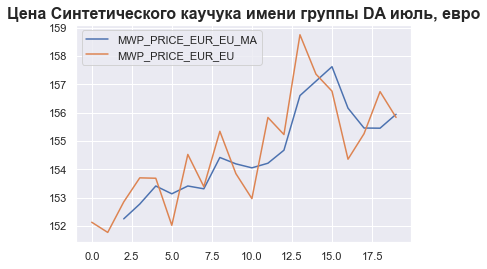

In [22]:
# График с базовой ценой(на заводе) в евро
plt.title('Цена Синтетического каучука имени группы DA июль, евро', fontsize=16, fontweight='bold')
plt.plot(df_all['MWP_PRICE_EUR_EU_MA'], label='MWP_PRICE_EUR_EU_MA')
plt.plot(df_all['MWP_PRICE_EUR_EU'], label='MWP_PRICE_EUR_EU')
plt.legend()
plt.show()

# Задание 2. Продолжение

Клиенты согласились на ваше предложение.
### Что нужно сделать?
Вам нужно написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно.



* В результате должен быть скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

In [34]:
# далее реализую фуекции для расчетов
customers

{'Monty': {'location': 'EU', 'volumes': 200, 'formula': 'moving_average'},
 'Triangle': {'location': 'CN', 'volumes': 30, 'formula': 'monthly'},
 'Stone': {'location': 'EU', 'volumes': 150, 'formula': 'moving_average'},
 'Poly': {'location': 'EU', 'volumes': 70, 'formula': 'monthly'}}

In [40]:
def location():     # Здесь выбирается нужная цена доставки

    if o.get('location') != 'EU':
        return CN_LOGISTIC_COST_USD
    else:
        return EU_LOGISTIC_COST_EUR




def volumes():      # Здесь выбирается нужная скидка
    if o.get('volumes') < 100:
        return 1
    elif 100 < o.get('volumes') < 300:
        return 1 - 0.05
    else:
        return 0.9
        


def formula():      # Здесь выбирается нужная формула для итогового расчета, цена цент за килограмм в центах (согласно бирже), 
                    # перевожу в долл/тонну (*1000/100)
    if o.get('formula') == 'moving_average':
        return df_all['MWP_PRICE_EUR_EU_MA'] * volumes() * 10 + location()
    else:
        if o.get('location') == 'EU':
            return df_all['MWP_PRICE_EUR_EU'] * volumes() * 10 + location()
        else:
            return df_all['MWP_PRICE_USD_CN'] * volumes()* 10 + location()






In [41]:
for client in customers.values():
    print(client)

{'location': 'EU', 'volumes': 200, 'formula': 'moving_average'}
{'location': 'CN', 'volumes': 30, 'formula': 'monthly'}
{'location': 'EU', 'volumes': 150, 'formula': 'moving_average'}
{'location': 'EU', 'volumes': 70, 'formula': 'monthly'}


In [45]:
# В цикле перебираю клиентов, подставляю функцию formula, она, в свою очередь, принимает переменные из двух первых функций
total = []
for client in customers.values():
    
    o = client
    client_price = formula()
    total.append(client_price)

print(total[3])

0     1551.310691
1     1547.714337
2     1558.484025
3     1566.974370
4     1566.834725
5     1550.223068
6     1575.239363
7     1563.857134
8     1583.403361
9     1568.471204
10    1559.644025
11    1588.284622
12    1582.253889
13    1617.481224
14    1603.570158
15    1597.571063
16    1573.556864
17    1582.541614
18    1597.401366
19    1588.294111
Name: MWP_PRICE_EUR_EU, dtype: float64


# Задание 3. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

### Что нужно сделать?
* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ
* Помните о PEP8

In [3]:
# import yourpackage

# Задание 4. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

### Что нужно сделать?
* Создайте отдельный пакет, который можно устанавливать с помощью pip
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в свой репозиторий

In [ ]:
# !pip install yourpackage
# import yourpackage